### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import skimage.io
import h5py
from torch.utils.data import Dataset, DataLoader, Sampler

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG
from chestxray.datasets import make_patch
from chestxray.visualize import show_batch

In [4]:
ls {PANDA_PATH}/

folds.csv     hdf5/                  test.csv   train_images/
folds_db.csv  sample_submission.csv  train.csv  train_label_masks/


### Load

In [5]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)

In [6]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


In [7]:
# paths = list(PANDA_IMGS.glob('*.jpeg'))
# file_ids = [p.stem.split("_")[0] for p in paths]
# train = TRAIN_DF[TRAIN_DF.image_id.isin(file_ids)].reset_index(drop=True).copy()

### Tiff to Patch

In [8]:
def tiff_to_patches(file_id):
    file_path = f"{PANDA_IMGS}/{file_id}.tiff"
    image = skimage.io.MultiImage(file_path)[CFG.tiff_layer]
    patch, _ = make_patch(image, patch_size=CFG.tile_sz, num_patch=CFG.num_tiles)
    return patch

In [9]:
p = tiff_to_patches(file_ids[1])

In [10]:
p.shape

(16, 256, 256, 3)

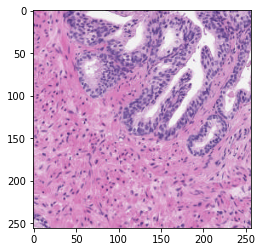

In [11]:
plt.imshow(p[6])

In [12]:
labels = train[CFG.target_col].values.astype(np.uint8)

In [13]:
patches = np.empty(shape=(len(train), CFG.num_tiles, CFG.tile_sz, CFG.tile_sz, 3), dtype=np.uint8)

In [14]:
%%time
for i, file_id in enumerate(train[CFG.img_id_col]):
    p = tiff_to_patches(file_id)
    patches[i] = p
    if (i+1)%100 == 0:
        print(f"Process {i+1} images")

Process 100 images
Process 200 images
Process 300 images
Process 400 images
Process 500 images
CPU times: user 1min 34s, sys: 24.4 s, total: 1min 58s
Wall time: 56.9 s


In [15]:
patches.shape, patches.dtype, labels.shape, labels.dtype

((500, 16, 256, 256, 3), dtype('uint8'))

### Process Real Data (by folds defined previously)

In [9]:
# we need data with folds
folds = pd.read_csv(PANDA_PATH/"folds.csv")

In [10]:
folds.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,3


In [11]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


In [12]:
folds.fold.unique()

array([3, 0, 1, 2])

In [13]:
fold = 3

In [14]:
# make it for every fold
train = folds[folds["fold"] == fold].copy()
print(f"Will process {len(train)} number of images")

Will process 2654 number of images


In [15]:
labels = train[CFG.target_col].values.astype(np.uint8)
patches = np.empty(shape=(len(train), CFG.num_tiles, CFG.tile_sz, CFG.tile_sz, 3), dtype=np.uint8)

for i, file_id in enumerate(train[CFG.img_id_col]):
    p = tiff_to_patches(file_id)
    patches[i] = p
    if (i+1)%100 == 0:
        print(f"Process {i+1} images")

Process 100 images
Process 200 images
Process 300 images
Process 400 images
Process 500 images
Process 600 images
Process 700 images
Process 800 images
Process 900 images
Process 1000 images
Process 1100 images
Process 1200 images
Process 1300 images
Process 1400 images
Process 1500 images
Process 1600 images
Process 1700 images
Process 1800 images
Process 1900 images
Process 2000 images
Process 2100 images
Process 2200 images
Process 2300 images
Process 2400 images
Process 2500 images
Process 2600 images


In [16]:
patches.shape, patches.dtype, labels.shape, labels.dtype

((2654, 16, 256, 256, 3), dtype('uint8'), (2654,), dtype('uint8'))

In [17]:
# we need some assertions here
train.iloc[82]

image_id         0896c0e0ee1979a0075927acb663f2a4
data_provider                          karolinska
isup_grade                                      0
gleason_score                                 0+0
fold                                            3
Name: 332, dtype: object

In [18]:
labels[82]

0

### Convert to HDF5

In [19]:
hdf5_dir = PANDA_PATH / "hdf5"
# hdf5_dir.mkdir()

In [20]:
def store_to_hdf5(file_name, images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, num_patches, H, W, C) to be stored
        labels       labels array, (N, 1) to be stored
    """

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{file_name}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    labels_set = file.create_dataset(
        "labels", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

In [21]:
file_name = f"patch{CFG.tile_sz}x{CFG.num_tiles}x{CFG.tiff_layer}_fold_{fold}"

In [22]:
file_name

'patch256x16x1_fold_3'

In [23]:
store_to_hdf5(file_name, patches, labels)

In [24]:
del patches, labels

In [25]:
def read_many_hdf5(file_name):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{file_name}.h5", "r+")

    images = np.array(file["/images"]).astype(np.uint8)
    labels = np.array(file["/labels"]).astype(np.uint8)

    return images, labels

In [26]:
imgs, labels = read_many_hdf5(file_name)

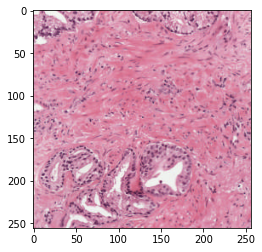

In [27]:
plt.imshow(imgs[-1,0])

In [28]:
labels[-1]

4

In [29]:
train.iloc[-1]

image_id         ffe9bcababc858e04840669e788065a1
data_provider                             radboud
isup_grade                                      4
gleason_score                                 4+4
fold                                            3
Name: 10615, dtype: object

In [31]:
img = skimage.io.MultiImage(f"{PANDA_IMGS}/ffe9bcababc858e04840669e788065a1.tiff")[1]

In [32]:
img,_ = make_patch(img, CFG.tile_sz, CFG.num_tiles)

In [33]:
img.shape

(16, 256, 256, 3)

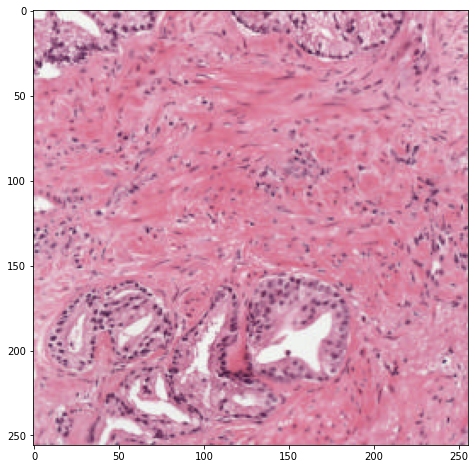

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(img[0])

### HDF5 Dataset

In [13]:
class H5PatchDataset(Dataset):
    """Represents an abstract HDF5 dataset.
    
    Input params:
        file_path: Path to the folder containing the dataset (one or multiple HDF5 files).
        fnames: h5 files to use.
        load_data: If True, loads all the data immediately into RAM. Use this if
            the dataset is fits into memory. Otherwise, leave this at false and 
            the data will load lazily.
        data_cache_size: Number of HDF5 files that can be cached in the cache (default=3).
    """
    def __init__(self, file_path, fnames, load_data=True, data_cache_size=2):
        super().__init__()
        self.data_cache_size = data_cache_size

        # Collect all h5 file paths
        p = Path(file_path)
        assert(p.is_dir())
        h5files = [p/fname for fname in fnames]
        if len(h5files) < 1:
            raise RuntimeError('No hdf5 datasets found')
        self.h5files = h5files
        
        self._full_len, self._common_len = self._get_lengths()
        self._cache = {} # key - file idx in self.h5files, value - opened file
        
    def _get_lengths(self):
        lenghts = []
        for h5file in self.h5files:
            with h5py.File(f"{h5file}", "r") as file:
                lenghts.append(len(file["/images"]))
        return sum(lenghts), max(lenghts)
    
    def _load_data(self, file_idx):
        file = h5py.File(f"{self.h5files[file_idx]}", "r")
        self._cache[file_idx] = file
        print(f"Add file {file_idx} to cache")
        
        if len(self._cache) > self.data_cache_size:
            remove_idx = min(self._cache) # remove min as the sampler randomly took indexes from bins (0:100), (100:200) and so on in sequence
            self._cache[remove_idx].close()
            self._cache.pop(remove_idx)
            
    def _get_data(self, file_idx, effective_idx, group):
        data = self._cache[file_idx][f"/{group}"][effective_idx]
        return data
            
    def __getitem__(self, index):
        file_idx = index // self._common_len
        if file_idx not in self._cache:
            self._load_data(file_idx)
        
        effective_idx = index - (file_idx * self._common_len)
        
        patch = self._get_data(file_idx, effective_idx, "images")
        patch = patch.astype(np.uint8)
#         normalized = normalize(image=patch)
#         patch = normalized["image"]

        patch = patch.transpose(0, 3, 1, 2)
        patch = np.ascontiguousarray(patch)
        
        label = self._get_data(file_idx, effective_idx, "labels")
        label = label.astype(np.int)
        return patch, label

    def __len__(self):
        return self._full_len
    

### Sampler

In [14]:
class SeqenceRandomSampler(Sampler):
    r"""Samples elements randomly from a given list of indices, without replacement.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, full_len, step):
        self.full_len = full_len
        self.step = step

    def __iter__(self):
        result = []
        indices = list(range(self.full_len))
        for i in range(0, self.full_len, self.step):
            part = indices[i:i+self.step]
            np.random.shuffle(part)
            result.extend(part)
        return (i for i in result)

    def __len__(self):
        return self.full_len

In [31]:
ds = H5PatchDataset(file_path=hdf5_dir, fnames=["patches500.h5", "patches500.h5"])

In [32]:
sampler = SeqenceRandomSampler(len(ds), ds._common_len)

In [33]:
debug_loader = DataLoader(ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=1)

In [34]:
%%time
for i, data in enumerate(debug_loader):
    imgs, lbls = data
#     if i == 10:
#         break

Add file 0 to cache
Add file 1 to cache
CPU times: user 148 ms, sys: 286 ms, total: 434 ms
Wall time: 3.84 s


In [35]:
imgs.shape

torch.Size([4, 16, 3, 256, 256])

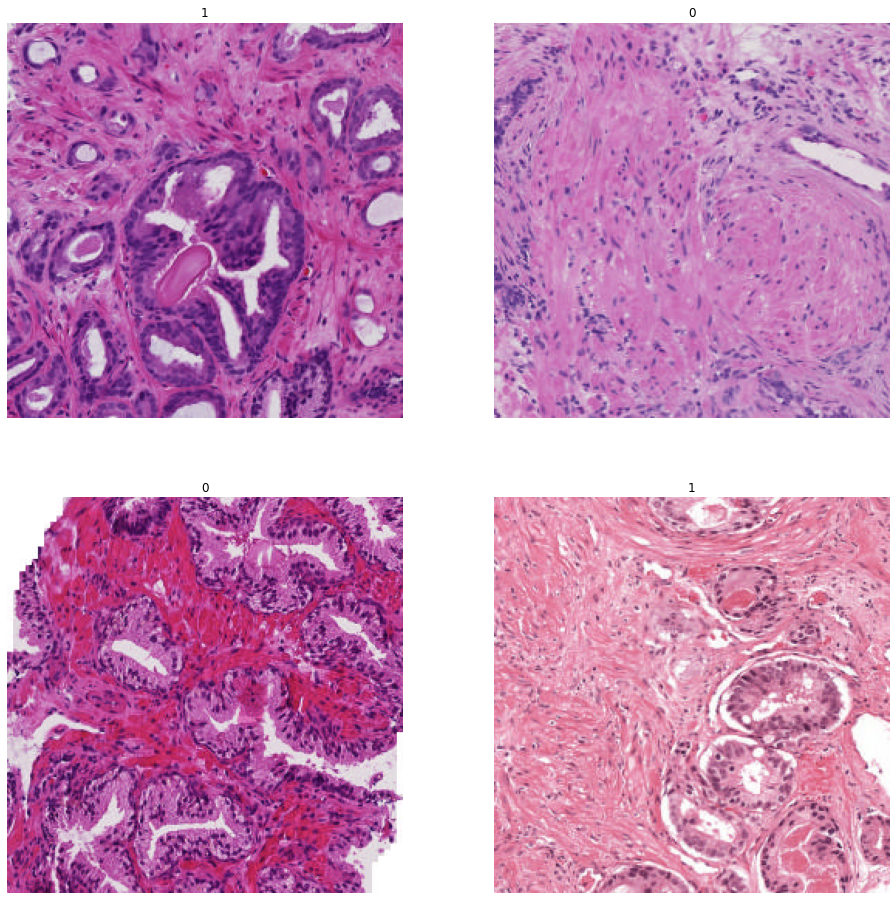

In [36]:
show_batch(imgs, lbls, denorm=False)